# Aproximace funkce – lineární regrese jako úloha LP (LAD)

Uvažujme, že máme skupinu bodů $$(x_i, y_i), \quad i = 1,\dots,n,$$
a chceme jimi **proložit křivku** (například přímku nebo polynom).

Klasická formulace lineární regrese (metoda nejmenších čtverců, OLS) hledá koeficienty
$$\beta_0, \beta_1$$
tak, aby minimalizovala součet čtverců odchylek

$$
\min E_{\text{OLS}} = \sum_{i=1}^n \bigl(\beta_0 + \beta_1 x_i - y_i\bigr)^2.
$$

Tato metoda je velmi rozšířená, ale **citlivá na odlehlé hodnoty** – velké odchylky jsou kvadraticky „penalizovány“.

---

## Regrese ve smyslu minimální absolutní odchylky (LAD)

Alternativou je **minimalizace absolutních odchylek** (LAD – Least Absolute Deviations):

$$
\min E_{\text{LAD}} = \sum_{i=1}^n \left|\beta_0 + \beta_1 x_i - y_i\right|.
$$

Výhoda LAD:

- chová se robustněji vůči odlehlým bodům,
- a hlavně – dá se elegantně převést na úlohu **lineárního programování**.

Zavedeme pomocné proměnné $e_i \ge 0$ a chceme, aby platilo

$$
\left|\beta_0 + \beta_1 x_i - y_i\right| \le e_i.
$$

To je ekvivalentní soustavě dvou nerovností

$$
-e_i \le \beta_0 + \beta_1 x_i - y_i \le e_i.
$$

Jako účelovou funkci pak minimalizujeme součet těchto odchylek:

$$
\min z = \sum_{i=1}^n e_i.
$$

Výsledný LP model:

$$
\begin{aligned}
\min\; & z = \sum_{i=1}^n e_i \\
\text{za podmínek}\; & \\
& \beta_0 + \beta_1 x_i - y_i \le e_i, \quad i = 1,\dots,n,\\
& y_i - (\beta_0 + \beta_1 x_i) \le e_i, \quad i = 1,\dots,n,\\
& e_i \ge 0, \quad i = 1,\dots,n,\\
& \beta_0, \beta_1 \in \mathbb{R}.
\end{aligned}
$$

Tuto myšlenku snadno rozšíříme na libovolnou lineární kombinaci **bázických funkcí**
$$
\varphi(\beta_0,\dots,\beta_k; x_i) = \sum_{j=0}^{k} \beta_j \theta_j(x_i),
$$
např. polynom $\varphi(x) = \beta_0 + \beta_1 x + \beta_2 x^2$.

Níže si ukážeme praktický příklad se skutečnými daty prodeje šamponů.


In [ ]:
# Načtení dat – prodeje šamponů z CSV souboru
# data z https://www.kaggle.com/datasets/djokester/sales-of-shampoo-over-a-three-year-period

import pandas as pd
import numpy as np

# We assume the CSV file is in the same directory as this notebook,
# with columns: "Month", "Sales of shampoo over a three year period".
# File name can be freely changed as needed.
csv_path = "shampoo_sales.csv"

sales = pd.read_csv(csv_path)

# Rename the sales column
sales.rename(
    columns={"Sales of shampoo over a three year period": "Prodeje"},
    inplace=True,
)

# Create a numeric time index t = 1,...,n (for regression x-values)
sales["Mesic"] = np.arange(1, len(sales) + 1)

# Rename  index for nicer plots
sales.set_index("Mesic", inplace=True)

print("Prvních několik řádků dat:")
display(sales.head())


Prvních několik řádků dat:


Month  Prodeje
Mesic               
1      1-01    266.0
2      1-02    145.9
3      1-03    183.1
4      1-04    119.3
5      1-05    180.3

## Vizuální pohled na data

Než začneme modelovat, je užitečné se na data podívat.  
Na ose $x$ budeme mít čas (měsíce $1,2,\dots$), na ose $y$ měřené prodeje.

Z grafu je obvykle vidět:

- zda je trend spíše lineární, kvadratický, exponenciální,
- zda jsou přítomné odlehlé hodnoty,
- jak moc se data „rozptylují“ kolem trendu.

U našeho datasetu prodejů šamponů bývá patrný **rostoucí a mírně zakřivený trend**, takže
polynom druhého stupně se jeví jako rozumná volba:

$$
\varphi(x) = \beta_0 + \beta_1 x + \beta_2 x^2.
$$


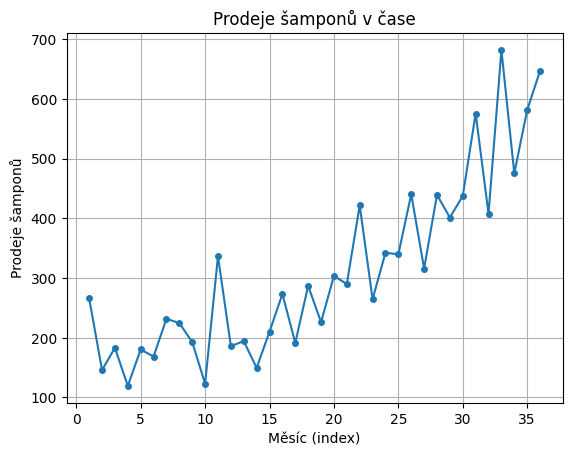

In [ ]:
# Vykreslení naměřených dat

import matplotlib.pyplot as plt

ax = sales["Prodeje"].plot(
    marker="o",
    markersize=4,
    linestyle="-",
)
ax.set_xlabel("Měsíc (index)")
ax.set_ylabel("Prodeje šamponů")
ax.set_title("Prodeje šamponů v čase")
ax.grid(True)
plt.show()


## LAD regrese jako lineární program

Budeme chtít odhadnout koeficienty $\beta_0, \beta_1, \beta_2$ v modelu

$$
\varphi(x_i) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2,
$$

tak, aby součet absolutních odchylek $\lvert \varphi(x_i) - y_i \rvert$ byl minimální.

### Maticový zápis

Definujme vektor parametrů

$$
\beta = (\beta_0, \beta_1, \beta_2)^T
$$

a matici $\Theta$ velikosti $n \times 3$ tak, že její řádek pro $x_i$ je

$$
\Theta_i = \bigl[1,\; x_i,\; x_i^2\bigr].
$$

Potom lze psát

$$
\varphi(x_i) = \Theta_i \cdot \beta,
$$

a vektor předpovědí jako

$$
\hat{y} = \Theta \beta.
$$

Pro každé $i$ zavedeme proměnnou $e_i \ge 0$ a přidáme dvojici nerovností

$$
\Theta_i \beta - y_i \le e_i, \qquad
y_i - \Theta_i \beta \le e_i.
$$

Účelová funkce:

$$
\min \sum_{i=1}^n e_i.
$$

V následující buňce tuto formulaci zavedeme v knihovně **PuLP**.


In [ ]:
# Sestavení LAD regresního modelu (polynom 2. stupně) jako LP

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Prepare numerical data
y = sales["Prodeje"].to_numpy(dtype=float)
x = sales.index.to_numpy(dtype=float)  # numeric month indices
n = len(y)

# Degree of polynomial (2 => beta_0, beta_1, beta_2)
degree = 2
num_beta = degree + 1

# Build Theta matrix with basis functions theta_k(x) = x^k
# Shape: (n, num_beta)
Theta = np.vstack([x ** k for k in range(num_beta)]).T

print("Shape of Theta matrix:", Theta.shape)  # (n, 3) for quadratic model

# Create LP model
model = LpProblem(name="LAD_regrese", sense=LpMinimize)

# Error variables e_i >= 0
eps = LpVariable.dicts("eps", range(n), lowBound=0)

# Regression coefficients beta_k (can be any real number)
beta = LpVariable.dicts("beta", range(num_beta), lowBound=None)

# Objective: minimize sum of absolute deviations
model += lpSum(eps[i] for i in range(n)), "Sum_of_absolute_errors"

# Constraints: -eps_i <= Theta_i * beta - y_i <= eps_i
for i in range(n):
    # Linear prediction at x_i: Theta_i dot beta
    prediction = lpSum(beta[k] * Theta[i, k] for k in range(num_beta))

    # Upper bound: prediction - y_i <= eps_i
    model += prediction - y[i] <= eps[i], f"Upper_{i}"

    # Lower bound: y_i - prediction <= eps_i
    model += y[i] - prediction <= eps[i], f"Lower_{i}"

print(model)


Shape of Theta matrix: (36, 3)
LAD_regrese:
MINIMIZE
1*eps_0 + 1*eps_1 + 1*eps_10 + 1*eps_11 + 1*eps_12 + 1*eps_13 + 1*eps_14 + 1*eps_15 + 1*eps_16 + 1*eps_17 + 1*eps_18 + 1*eps_19 + 1*eps_2 + 1*eps_20 + 1*eps_21 + 1*eps_22 + 1*eps_23 + 1*eps_24 + 1*eps_25 + 1*eps_26 + 1*eps_27 + 1*eps_28 + 1*eps_29 + 1*eps_3 + 1*eps_30 + 1*eps_31 + 1*eps_32 + 1*eps_33 + 1*eps_34 + 1*eps_35 + 1*eps_4 + 1*eps_5 + 1*eps_6 + 1*eps_7 + 1*eps_8 + 1*eps_9 + 0.0
SUBJECT TO
Upper_0: beta_0 + beta_1 + beta_2 - eps_0 <= 266

Lower_0: - beta_0 - beta_1 - beta_2 - eps_0 <= -266

Upper_1: beta_0 + 2 beta_1 + 4 beta_2 - eps_1 <= 145.9

Lower_1: - beta_0 - 2 beta_1 - 4 beta_2 - eps_1 <= -145.9

Upper_2: beta_0 + 3 beta_1 + 9 beta_2 - eps_2 <= 183.1

Lower_2: - beta_0 - 3 beta_1 - 9 beta_2 - eps_2 <= -183.1

Upper_3: beta_0 + 4 beta_1 + 16 beta_2 - eps_3 <= 119.3

Lower_3: - beta_0 - 4 beta_1 - 16 beta_2 - eps_3 <= -119.3

Upper_4: beta_0 + 5 beta_1 + 25 beta_2 - eps_4 <= 180.3

Lower_4: - beta_0 - 5 beta_1 - 25 beta_

## Řešení LAD modelu a interpretace koeficientů

Teď model vyřešíme:

- zjistíme status řešiče,
- vypíšeme koeficienty $\beta_0, \beta_1, \beta_2$,
- spočteme předpovězené hodnoty $\hat{y}_{\text{LAD}} = \Theta \hat{\beta}$.

Pro srovnání zároveň spočteme klasickou regresi **OLS**:

$$
\hat{\beta}_{\text{OLS}} = \arg\min_\beta \|\Theta \beta - y\|_2^2,
$$

kterou získáme pomocí `numpy.linalg.lstsq`.

Výsledek vykreslíme do jednoho grafu:

- originální data,
- LAD predikci,
- OLS predikci.


In [ ]:
# Řešení LAD modelu a výpočet predikcí

# Solve LAD LP
result_status = model.solve()

print(f"Status řešiče: {LpStatus[result_status]}")
print(f"Minimální součet absolutních odchylek: {value(model.objective):.3f}\n")

# Extract LAD coefficients
beta_LAD = np.array([beta[k].varValue for k in range(num_beta)], dtype=float)
print("Koeficienty LAD (beta):", beta_LAD)

# LAD predictions
y_hat_LAD = Theta @ beta_LAD

# OLS solution using least squares
beta_OLS, *_ = np.linalg.lstsq(Theta, y, rcond=None)
print("Koeficienty OLS (beta):", beta_OLS)

# OLS predictions
y_hat_OLS = Theta @ beta_OLS

# Store predictions back to DataFrame for plotting
sales["Pred_LAD"] = y_hat_LAD
sales["Pred_OLS"] = y_hat_OLS

print("\nUkázka tabulky s predikcemi:")
display(sales.head())


Status řešiče: Optimal
Minimální součet absolutních odchylek: 1661.146

Koeficienty LAD (beta): [199.28594    -6.924375    0.5096875]
Koeficienty OLS (beta): [202.87887955  -5.88014822   0.48538437]

Ukázka tabulky s predikcemi:


Month  Prodeje    Pred_LAD    Pred_OLS
Mesic                                       
1      1-01    266.0  192.871253  197.484116
2      1-02    145.9  187.475940  193.060121
3      1-03    183.1  183.100003  189.606894
4      1-04    119.3  179.743440  187.124437
5      1-05    180.3  177.406252  185.612748

## Porovnání LAD a OLS vizuálně

Nyní do jednoho grafu vykreslíme:

- naměřené hodnoty prodejů (body a spojnice),
- průběh LAD regrese,
- průběh OLS regrese.

Obě metody budou často velmi podobné, ale:

- LAD mívá „plošší“ průběh v místech s odlehlými hodnotami,
- OLS se naopak více snaží „vyhovět“ bodům s velkou odchylkou,
  protože kvadratická penalizace je silnější.


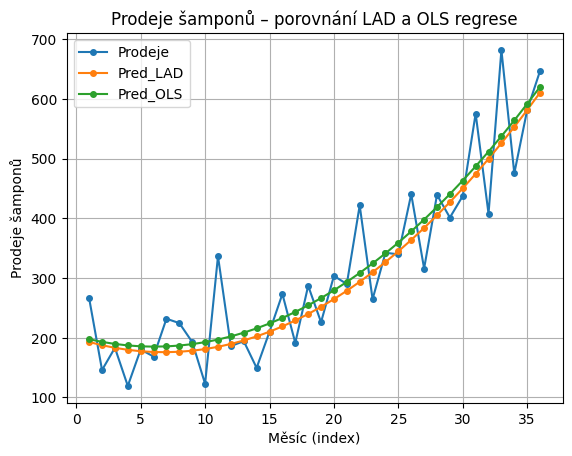

In [ ]:
# Vykreslení dat spolu s LAD a OLS křivkami

ax = sales[["Prodeje", "Pred_LAD", "Pred_OLS"]].plot(
    marker="o",
    markersize=4,
)
ax.set_xlabel("Měsíc (index)")
ax.set_ylabel("Prodeje šamponů")
ax.set_title("Prodeje šamponů – porovnání LAD a OLS regrese")
ax.grid(True)
plt.show()
